# Text categorization model using the features derived from BERT

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
ORIGINAL_DATA_DIR = os.path.join("data")
BERT_FEATURE_DIR = "bert_output_data"

In [3]:
train_df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_train.csv"))
print(train_df.shape)

bert_vectors_train = []
with open(os.path.join(BERT_FEATURE_DIR, "train.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_vectors_train.append(t["layers"][0]["values"])
                break
print(len(bert_vectors_train))

X_train = np.array(bert_vectors_train)
y_train = train_df["native_language"].values

(6000, 2)
6000


In [4]:
eval_df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_eval.csv"))
print(eval_df.shape)

bert_vectors_eval = []
with open(os.path.join(BERT_FEATURE_DIR, "eval.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_vectors_eval.append(t["layers"][0]["values"])
                break
print(len(bert_vectors_eval))

X_eval = np.array(bert_vectors_eval)
y_eval = eval_df["native_language"].values

(2000, 2)
2000


In [5]:
test_df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_test.csv"))
print(test_df.shape)

bert_vectors_test = []
with open(os.path.join(BERT_FEATURE_DIR, "test.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_vectors_test.append(t["layers"][0]["values"])
                break
print(len(bert_vectors_test))

X_test = np.array(bert_vectors_test)
y_test = test_df["native_language"].values

(2000, 2)
2000


# Logistic Regression

In [6]:
lr_model = LogisticRegression(penalty="l2", C=1.0)
lr_model.fit(X_train, y_train)

print("Training Accuarcy: ", lr_model.score(X_train, y_train))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training Accuarcy:  0.7346666666666667


Evaluation for each class
              precision    recall  f1-score   support

      Arabic       0.50      0.49      0.50       200
   Cantonese       0.33      0.34      0.33       200
    Japanese       0.46      0.49      0.48       200
      Korean       0.48      0.46      0.47       200
    Mandarin       0.32      0.32      0.32       200
      Polish       0.47      0.51      0.49       200
     Russian       0.51      0.57      0.54       200
     Spanish       0.52      0.52      0.52       200
        Thai       0.66      0.60      0.63       200
  Vietnamese       0.42      0.36      0.39       200

    accuracy                           0.47      2000
   macro avg       0.47      0.47      0.47      2000
weighted avg       0.47      0.47      0.47      2000


**********************************************************************************************



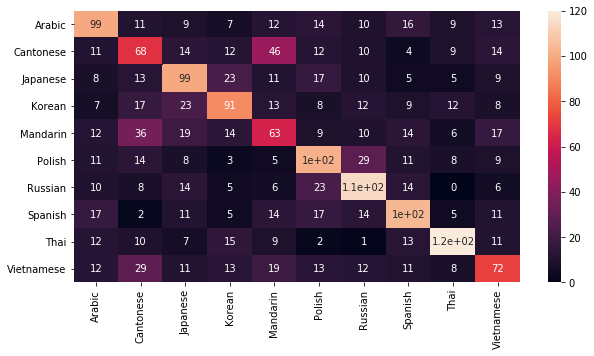

**********************************************************************************************

Misclassification for each class
     Language  Misclassification
0      Arabic              10.05
0   Cantonese              13.60
0    Japanese              10.85
0      Korean              10.30
0    Mandarin              13.60
0      Polish              10.65
0     Russian               9.70
0     Spanish               9.65
0        Thai               7.10
0  Vietnamese              11.30

**********************************************************************************************

Misclassification between each pair of classes
     Language   Predicted Misclassification
0     Russian        Thai                 0
0        Thai     Russian                 1
0     Spanish   Cantonese                 2
0        Thai      Polish                 2
0      Polish      Korean                 3
0   Cantonese     Spanish                 4
0    Japanese     Spanish                 5
0      Polis

In [15]:
# Adding predicted value in the dataframe
test_df['predicted1'] = lr_model.predict(X_test)
# Class list
list_of_languages = sorted(test_df['native_language'].unique())
# Precision, recall, f-measure and support for each class
print("Evaluation for each class")
print(classification_report(y_test,test_df['predicted1'].values,target_names=list_of_languages))
print()
print("**********************************************************************************************")
print()


# Confusion matrix
matrix = confusion_matrix(test_df['native_language'], test_df['predicted1'])
plt.figure(figsize = (10,5))
ax = sns.heatmap(matrix, annot=True, xticklabels=list_of_languages, yticklabels=list_of_languages)
plt.show()
print("**********************************************************************************************")
print()


# Calculate misclassification
test_predicted = test_df.groupby('predicted1').count()['native_language']
test_misclassifications = []
for i in range(len(list_of_languages)):
    misclassification = ((200 - matrix[i][i] + (test_predicted[i] - matrix[i][i])) / 2000) * 100
    test_misclassifications.append(misclassification)

# Misclassification for each class into one dataframe
evaluation_by_class = pd.DataFrame(columns=['Language', 'Misclassification'])
for i in range(len(list_of_languages)):
    evaluation_by_class = evaluation_by_class.append(pd.DataFrame([[list_of_languages[i], test_misclassifications[i]]], 
                                        columns=['Language', 'Misclassification']))
print("Misclassification for each class")
print(evaluation_by_class.to_string())
print()
print("**********************************************************************************************")
print()


# Evaluate misclassification between all classes
evaluation_between_classes = pd.DataFrame(columns=['Language', 'Predicted', 'Misclassification'])
for i in list_of_languages:
    for j in list_of_languages:
        if(i != j):
            evaluation_between_classes = evaluation_between_classes.append(pd.DataFrame([[i, j, 
                                                              matrix[list_of_languages.index(i)][list_of_languages.index(j)]]], 
                                                              columns=['Language', 'Predicted', 'Misclassification']))
print("Misclassification between each pair of classes")
print(evaluation_between_classes.sort_values(by=['Misclassification']).to_string())
print()
print("**********************************************************************************************")
print()


print("Summary")
print("Total records:", test_df.shape[0])
print("Incorrect predictions:", evaluation_between_classes['Misclassification'].sum())
print("Correct predictions:", (test_df.shape[0] - evaluation_between_classes['Misclassification'].sum()))

#  Neural Network

In [8]:
nn_model = MLPClassifier(solver='lbfgs')
nn_model.fit(X_train, y_train) 

print("Training Accuarcy: ", nn_model.score(X_train, y_train))

Training Accuarcy:  0.6841666666666667


Evaluation for each class
              precision    recall  f1-score   support

      Arabic       0.51      0.43      0.47       200
   Cantonese       0.33      0.34      0.34       200
    Japanese       0.45      0.46      0.45       200
      Korean       0.47      0.45      0.46       200
    Mandarin       0.32      0.34      0.33       200
      Polish       0.44      0.47      0.46       200
     Russian       0.50      0.55      0.52       200
     Spanish       0.55      0.52      0.53       200
        Thai       0.58      0.59      0.59       200
  Vietnamese       0.39      0.38      0.38       200

    accuracy                           0.45      2000
   macro avg       0.45      0.45      0.45      2000
weighted avg       0.45      0.45      0.45      2000


**********************************************************************************************



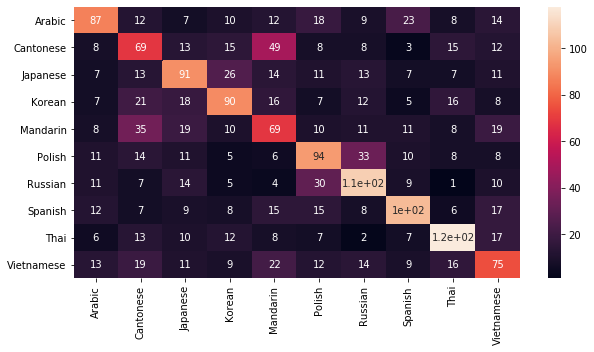

**********************************************************************************************

Misclassification for each class
     Language  Misclassification
0      Arabic               9.80
0   Cantonese              13.60
0    Japanese              11.05
0      Korean              10.50
0    Mandarin              13.85
0      Polish              11.20
0     Russian              10.05
0     Spanish               9.05
0        Thai               8.35
0  Vietnamese              12.05

**********************************************************************************************

Misclassification between each pair of classes
     Language   Predicted Misclassification
0     Russian        Thai                 1
0        Thai     Russian                 2
0   Cantonese     Spanish                 3
0     Russian    Mandarin                 4
0     Russian      Korean                 5
0      Korean     Spanish                 5
0      Polish      Korean                 5
0        Tha

In [16]:
# Adding predicted value in the dataframe
test_df['predicted2'] = nn_model.predict(X_test)
# Class list
list_of_languages = sorted(test_df['native_language'].unique())
# Precision, recall, f-measure and support for each class
print("Evaluation for each class")
print(classification_report(y_test,test_df['predicted2'].values,target_names=list_of_languages))
print()
print("**********************************************************************************************")
print()


# Confusion matrix
matrix = confusion_matrix(test_df['native_language'], test_df['predicted2'])
plt.figure(figsize = (10,5))
ax = sns.heatmap(matrix, annot=True, xticklabels=list_of_languages, yticklabels=list_of_languages)
plt.show()
print("**********************************************************************************************")
print()


# Calculate misclassification
test_predicted = test_df.groupby('predicted2').count()['native_language']
test_misclassifications = []
for i in range(len(list_of_languages)):
    misclassification = ((200 - matrix[i][i] + (test_predicted[i] - matrix[i][i])) / 2000) * 100
    test_misclassifications.append(misclassification)

# Misclassification for each class into one dataframe
evaluation_by_class = pd.DataFrame(columns=['Language', 'Misclassification'])
for i in range(len(list_of_languages)):
    evaluation_by_class = evaluation_by_class.append(pd.DataFrame([[list_of_languages[i], test_misclassifications[i]]], 
                                        columns=['Language', 'Misclassification']))
print("Misclassification for each class")
print(evaluation_by_class.to_string())
print()
print("**********************************************************************************************")
print()


# Evaluate misclassification between all classes
evaluation_between_classes = pd.DataFrame(columns=['Language', 'Predicted', 'Misclassification'])
for i in list_of_languages:
    for j in list_of_languages:
        if(i != j):
            evaluation_between_classes = evaluation_between_classes.append(pd.DataFrame([[i, j, 
                                                              matrix[list_of_languages.index(i)][list_of_languages.index(j)]]], 
                                                              columns=['Language', 'Predicted', 'Misclassification']))
print("Misclassification between each pair of classes")
print(evaluation_between_classes.sort_values(by=['Misclassification']).to_string())
print()
print("**********************************************************************************************")
print()


print("Summary")
print("Total records:", test_df.shape[0])
print("Incorrect predictions:", evaluation_between_classes['Misclassification'].sum())
print("Correct predictions:", (test_df.shape[0] - evaluation_between_classes['Misclassification'].sum()))